In [2]:
import random

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from scikeras.wrappers import KerasClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense

from sklearn.inspection import permutation_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

plt.style.use('ggplot')

In [3]:
mlflow.login()

2024/07/15 09:16:39 INFO mlflow.utils.credentials: Successfully connected to MLflow hosted tracking server! Host: https://community.cloud.databricks.com.


In [4]:
target = 'labels'
class_names = ['Blight', 'Common Rust', 'Gray Leaf Spot', 'Healthy']

In [5]:
train = pl.read_parquet('data/train_data.parquet')
val = pl.read_parquet('data/validation_data.parquet')
test = pl.read_parquet('data/test_data.parquet')

In [25]:
X_train, y_train = train.drop(target), train[target]
X_val, y_val = val.drop(target), val[target]
X_test, y_test = test.drop(target), test[target]

In [7]:
mlflow.set_experiment('/corn-disease-hybrid-ml')

<Experiment: artifact_location='dbfs:/databricks/mlflow-tracking/3077886415753277', creation_time=1720696334031, experiment_id='3077886415753277', last_update_time=1720966557769, lifecycle_stage='active', name='/corn-disease-hybrid-ml', tags={'mlflow.experiment.sourceName': '/corn-disease-hybrid-ml',
 'mlflow.experimentType': 'MLFLOW_EXPERIMENT',
 'mlflow.ownerEmail': 'vsefareez@student.unmul.ac.id',
 'mlflow.ownerId': '3913636749821090'}>

In [8]:
# Custom cross-validation generator that only uses the training and validation sets
class PredefinedSplit:
    def __init__(self, test_fold):
        self.test_fold = test_fold

    def split(self, X, y=None, groups=None):
        train_indices = np.where(self.test_fold == -1)[0]
        test_indices = np.where(self.test_fold == 0)[0]
        yield train_indices, test_indices

    def get_n_splits(self, X, y=None, groups=None):
        return 1

In [27]:
def get_feature_importance(estimator):
    estimator.fit(X_train, y_train)
    return permutation_importance(estimator, X_val, y_val, random_state=42, n_jobs=-1)


def filter_feature(perm, X):
    # take top 5% of the important feature from df
    top_importances_subset = 0.05
    top_importances = int(X.shape[1] * top_importances_subset)
    indices = np.argsort(perm.importances_mean)[::-1][:top_importances]
    return X.select([X.columns[i] for i in indices])

In [28]:
def log_feature_selection(estimator):
    perm = get_feature_importance(estimator)
    train_filtered = filter_feature(perm, X_train)
    val_filtered = filter_feature(perm, X_val)
    test_filtered = filter_feature(perm, X_test)
    mlflow.log_params(estimator.get_params())

    train_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_train_filtered.parquet')
    val_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_val_filtered.parquet')
    test_filtered.write_parquet(f'.artifacts/{estimator.__class__.__name__}_test_filtered.parquet')

    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_train_filtered.parquet',
                        'filtered_feature')
    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_val_filtered.parquet', 'filtered_feature')
    mlflow.log_artifact(f'.artifacts/{estimator.__class__.__name__}_test_filtered.parquet', 'filtered_feature')
    return train_filtered, val_filtered, test_filtered

In [58]:
def log_cv_results(cv_results, estimator_name):
    cv_results_df = pl.DataFrame(cv_results, strict=False)
    param_col = [pl.col(col).map_elements(lambda x: x) for col in cv_results_df.columns if col.startswith('param_')]
    cv_results_df.select(
        pl.col('split0_test_score'),
        pl.col('rank_test_score'),
        *param_col
    ).write_csv(f'.artifacts/{estimator_name}_cv_results.csv')
    mlflow.log_artifact(f'.artifacts/{estimator_name}_cv_results.csv')

In [59]:
def evaluate_model(estimator, X_test):
    y_pred = estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    confusion = confusion_matrix(y_test, y_pred, normalize='true')
    return accuracy, recall, precision, confusion

In [60]:
def log_cm(confusion):
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["font.size"] = 10
    fig, ax = plt.subplots(figsize=(7, 6), dpi=300)
    sns.heatmap(confusion, annot=True, fmt='.1%', cmap='Blues',
                ax=ax, annot_kws={"fontsize": 11},
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted Class')
    ax.set_ylabel('Actual Class')
    mlflow.log_figure(fig, 'confusion_matrix.png')
    plt.show()
    plt.close(fig)

In [66]:
def tune_hyperparameter(estimator, param_grid, select_feature=False, name=None):
    if not name:
        name = estimator.__class__.__name__
        
    with mlflow.start_run(run_name=f'tune_{name}_{random.randint(0, 1000)}', tags={'tuning': 'true'}):
        if select_feature:
            X_train_filtered, X_val_filtered, X_test_filtered = log_feature_selection(estimator)
            mlflow.set_tag('feature_selection', 'true')
            test_fold = np.concatenate([np.full(len(X_train_filtered), -1), np.full(len(X_val_filtered), 0)])
            X_combined = np.concatenate((X_train_filtered, X_val_filtered), axis=0)
            y_combined = np.concatenate((y_train, y_val), axis=0)
        else:
            test_fold = np.concatenate([np.full(len(X_train), -1), np.full(len(X_val), 0)])
            X_combined = np.concatenate((X_train, X_val), axis=0)
            y_combined = np.concatenate((y_train, y_val), axis=0)

        random_search = RandomizedSearchCV(estimator,
                                           param_grid,
                                           scoring='accuracy',
                                           n_iter=10,
                                           n_jobs=-1,
                                           verbose=2,
                                           cv=PredefinedSplit(test_fold))
        random_search.fit(X_combined, y_combined)
        mlflow.log_params({f'best_{k}': v for k,v in random_search.best_params_.items()})
        mlflow.log_param('scoring', 'accuracy')
        mlflow.log_metric('best_score', random_search.best_score_)
        log_cv_results(random_search.cv_results_, estimator.__class__.__name__)
        mlflow.sklearn.log_model(random_search.best_estimator_, 'best_model')

        if select_feature:
            accuracy, recall, precision, confusion = evaluate_model(random_search.best_estimator_, X_test_filtered)
        else:
            accuracy, recall, precision, confusion = evaluate_model(random_search.best_estimator_, X_test)
        mlflow.log_metrics({
            'test_accuracy': accuracy,
            'test_recall': recall,
            'test_precision': precision})
        log_cm(confusion)
    return random_search.best_params_

In [67]:
def train_model(estimator, select_feature=False, name=None):
    if not name:
        name = estimator.__class__.__name__
        
    with mlflow.start_run(run_name=f'train_{name}_{random.randint(0, 1000)}', tags={'tuning': 'false'}):
        if select_feature:
            X_train_filtered, X_val_filtered, X_test_filtered = log_feature_selection(estimator)
            mlflow.set_tag('feature_selection', 'true')
            estimator.fit(X_train_filtered, y_train)
        else:
            estimator.fit(X_train, y_train)
            
        mlflow.log_params(estimator.get_params())
        mlflow.sklearn.log_model(estimator, 'best_model')

        if select_feature:
            accuracy, recall, precision, confusion = evaluate_model(estimator, X_test_filtered)
        else:
            accuracy, recall, precision, confusion = evaluate_model(estimator, X_test)
        mlflow.log_metrics({
            'test_accuracy': accuracy,
            'test_recall': recall,
            'test_precision': precision})
        log_cm(confusion)

In [68]:
def create_estimator(estimator, **kwargs):
    return estimator(**kwargs)

In [69]:
def get_model(meta, compile_kwargs):
    n_features_in = meta['n_features_in_']
    inputs = keras.Input(shape=(n_features_in,))
    x = Dense(4, activation='softmax')(inputs)
    model = keras.Model(inputs=inputs, outputs=x)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=compile_kwargs['optimizer'], metrics=['accuracy'])
    return model

In [ ]:
# nn = KerasClassifier(
#     model=get_model,
#     epochs=25,
#     optimizer='adam',
#     optimizer__learning_rate=0.0001,
#     random_state=42,
#     verbose=0
# )

for fs in [True, False]:
    # with hyperparameter tuning
    best_param = tune_hyperparameter(
        create_estimator(KerasClassifier, model=get_model, epochs=25, random_state=42, verbose=0, optimizer='adam', optimizer__learning_rate=0.0001),
        {
            'optimizer__learning_rate': [0.0001, 0.001, 0.01],
            'optimizer': ['adam', 'sgd'],
        },
        select_feature=fs
    )
    # without hyperparameter tuning
    train_model(
        create_estimator(KerasClassifier, model=get_model, epochs=25, random_state=42, verbose=0, optimizer='adam', optimizer__learning_rate=0.0001),
        select_feature=fs
    )
    # train with boosting with the best hyperparameters
    train_model(
        create_estimator(
            AdaBoostClassifier,
            estimator=KerasClassifier(model=get_model, epochs=25, random_state=42, verbose=0, **best_param),
            algorithm='SAMME',
            random_state=42
        ),
        select_feature=fs,
        name='BoostedKerasClassifier'
    )

In [22]:
for fs in [True, False]:
    # with hyperparameter tuning
    _ = tune_hyperparameter(
        create_estimator(
            AdaBoostClassifier,
            estimator=DecisionTreeClassifier(random_state=42),
            algorithm='SAMME',
            random_state=42
        ),
        {
            'n_estimators': [20, 100, 500, 50],
            'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4, 1],
            'estimator__min_samples_leaf': [1, 10, 50],
            'estimator__max_leaf_nodes': [2, 8, 32, 128, None]
        },
        select_feature=fs
    )

Fitting 1 folds for each of 10 candidates, totalling 10 fits


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
2024/07/12 16:00:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2024/07/12 16:00:13 WARNING mlflow.models.model: Model logged without a signature. Signatures will be required for upcoming model registry features as they validate model inputs and denote the expected schema of model outputs. Please visit https://www.mlflow.org/docs/2.14.2/models.html#set-s

Uploading artifacts:   0%|          | 0/5 [00:00<?, ?it/s]

D:\Projects\corn-disease\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


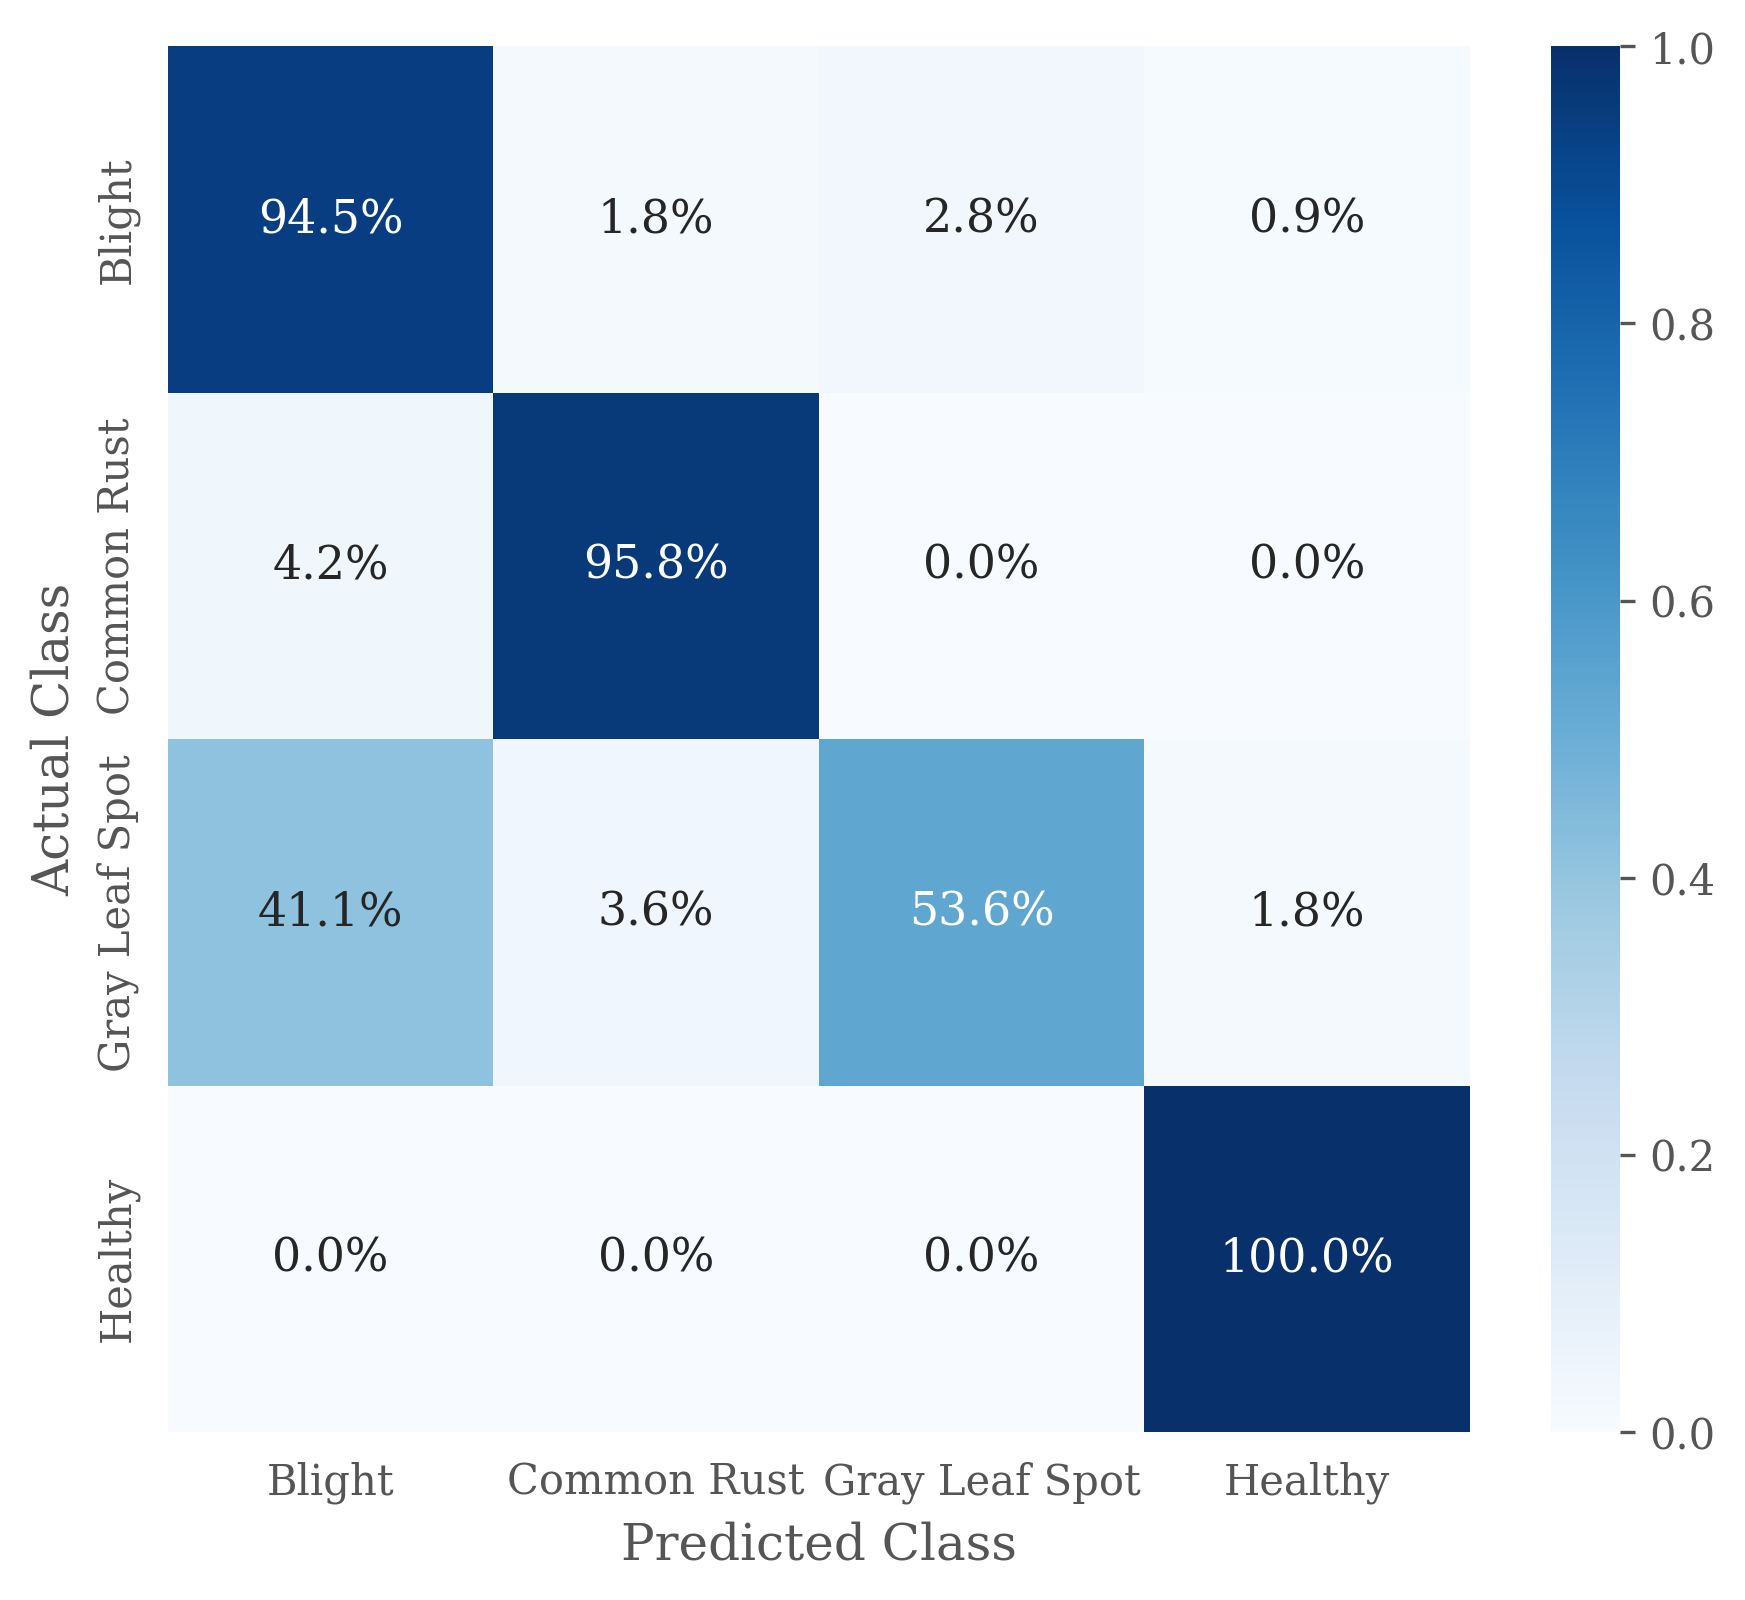

In [17]:
rf = RandomForestClassifier(random_state=42)

for fs in [True, False]:
    # with hyperparameter tuning
    _ = tune_hyperparameter(
        create_estimator(RandomForestClassifier, random_state=42),
        {
            'max_depth': [1, 16, 64],
            'n_estimators': [1, 8, 32],
            'min_samples_leaf': [1, 4, 16],
        },
        select_feature=fs
    )

In [ ]:
for fs in [True, False]:
    # with hyperparameter tuning
    tune_hyperparameter(
        create_estimator(AdaBoostClassifier, estimator=LogisticRegression(random_state=42), algorithm='SAMME', random_state=42),
        {
            'n_estimators': [20, 100, 500, 50],
            'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4, 1],
            'estimator__tol': [1e-5, 1e-8, 1e-4],
            'estimator__C': [0.01, 0.1, 1],
            'estimator__max_iter': [1000, 2000, 3000]
        },
        select_feature=fs,
        name='BoostedLogisticRegression'
    )

In [ ]:
for fs in [True, False]:
    # with hyperparameter tuning
    tune_hyperparameter(
        AdaBoostClassifier(SVC(random_state=42), algorithm='SAMME', random_state=42),
        {
            'n_estimators': [20, 100, 500, 50],
            'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.4, 1],
            'estimator__C': [1e-5, 0.0001, 0.001, 0.01, 0.1, 1, 10],
            'estimator__kernel': ['linear', 'rbf'],
            'estimator__gamma': ['scale', 'auto'],
        },
        select_feature=fs,
        name='BoostedSVC'
    )